<a href="https://colab.research.google.com/github/Yash-Jumde/Colab-Notebooks/blob/main/NLP_to_classify_medical_abstracts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we implement the deep learning model from the 2017 paper **"PubMed 200k RCT: A Dataset for Sequential Sentence Classification in Medical Abstracts."**

Problem with the given dataset is that it is not structured thus, can be hard to read. This slows down the researchers going through literarture looking for appropriate information.

Therefore, the NLP model should be able to classify sentences into various sections such as objective, methods, results, etc.

Data

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 28.42 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


Choosing a smaller dataset for faster experimentation

In [ ]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [ ]:
data_directory = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# getting all the filenames
import os
filenames = [data_directory + filename for filename in os.listdir(data_directory)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

Preprocessing the data

In [ ]:
# function that reads the lines of a document

def read_lines(filename):
  with open(filename) as f:
    return f.readlines()


In [ ]:
# Looking at train.txt
train_lines = read_lines(data_directory + "train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Here, each sentence is prefixed at the start of each line separated by a tab (\t) and each sentence finishes with a new line (\n).

If the line begins with ###, mark it as an abstract ID and begining of a new abstract. similary, if a line begins with \n, mark it as the end of the abstract.

Text before \t is the label and after it is the text.

In [ ]:
def preprocess_text(filename):
  input_lines = read_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith('###'):
      abstract_id = line
      abstract_lines  = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text = abstract_line.split("\t")
        line_data["target"] = target_text[0]
        line_data["text"] = target_text[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else:
      abstract_lines += line

  return abstract_samples


In [ ]:
train_samples = preprocess_text(data_directory + 'train.txt')
val_samples = preprocess_text(data_directory + 'dev.txt')
test_samples = preprocess_text(data_directory + 'test.txt')
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [ ]:
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [ ]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(10)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

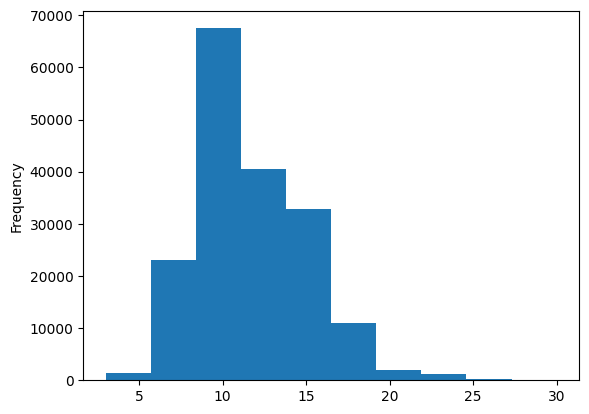

In [ ]:
train_df.total_lines.plot.hist()

In [ ]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [ ]:
# One hot encoding the labels
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
# Label encoding labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# class names and number of classes
class_names = label_encoder.classes_
num_classes = len(class_names)
class_names, num_classes

(array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object),
 5)

Baseline Model: TF-IDF Multinomial Naive Bayes

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_1 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_1.fit(train_sentences,
            train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
model_1.score(val_sentences, val_labels_encoded)

0.7218323844829869

It has 72.18% accuracy on the validation dataset.

In [ ]:
baseline_preds = model_1.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
# Function to calculate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def calculate_results(y_true, y_pred):
  # accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # precision, recall and f1 score using "weighted average"
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
baseline_results = calculate_results(val_labels_encoded,  baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

Preparing the data for deep learning models.

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers

In [ ]:
sentence_lengths = [len(sentence.split()) for sentence in train_sentences]
avg_length = np.mean(sentence_lengths)
avg_length

26.338269273494777

(array([1.5999e+05, 1.8760e+04, 1.1510e+03, 9.9000e+01, 2.8000e+01,
        1.0000e+01, 2.0000e+00]),
 array([  1.        ,  43.14285714,  85.28571429, 127.42857143,
        169.57142857, 211.71428571, 253.85714286, 296.        ]),
 <BarContainer object of 7 artists>)

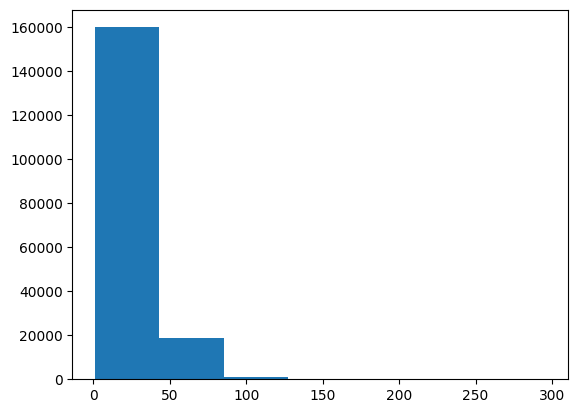

In [ ]:
# Sentence length distribution
import matplotlib.pyplot as plt
plt.hist(sentence_lengths, bins=7)

In [ ]:
# Length of sentence that can cover 95% of the lengths.
output_sequence_length = int(np.percentile(sentence_lengths, 95))
output_sequence_length

55

We can use this value to for the tokenization layer.

In [ ]:
# Maximum length of sentence in the training set.
max(sentence_lengths)

296

Text vectorizer

[PubMed 200k RCT Paper](https://arxiv.org/pdf/1710.06071.pdf) has suggested a vocavulary size of 68,000

In [ ]:
max_tokens = 68000

In [ ]:
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens,
                                    output_sequence_length = output_sequence_length)

In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:
# Testing the text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized Text:\n{text_vectorizer([target_sentence])}")

Text:
a total of @ consecutive inpatients with a medical diagnosis of pleural effusion .

Length of text: 14

Vectorized Text:
[[   8   76    4  753 3817    7    8  274  536    4 4415 5755    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [ ]:
# Data about words in the vocabulary.
text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words: {len(text_vocab)}")
print(f"Most Common words: {text_vocab[:5]}")
print(f"Least common words: {text_vocab[-5:]}")

Number of words: 64841
Most Common words: ['', '[UNK]', 'the', 'and', 'of']
Least common words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

Creating custom text embedding

In [ ]:
token_embedded = layers.Embedding(input_dim=len(text_vocab),
                                  output_dim=128,
                                  mask_zero=True,
                                  name="token_embedding")

# testing the embedding layer
print(f"Before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"After vectorization:\n{vectorized_sentence}")
embedded_sentence = token_embedded(vectorized_sentence)
print(f"After embedding:\n{embedded_sentence}")

Before vectorization:
a total of @ consecutive inpatients with a medical diagnosis of pleural effusion .

After vectorization:
[[   8   76    4  753 3817    7    8  274  536    4 4415 5755    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]
After embedding:
[[[-0.0185596  -0.01827139  0.02496975 ... -0.02400358  0.03059581
   -0.04651033]
  [ 0.03401205 -0.0182895  -0.04236523 ... -0.01417717 -0.00506854
    0.04602513]
  [-0.01504542 -0.04094775 -0.02657843 ...  0.03706325  0.00655134
   -0.01143677]
  ...
  [ 0.02304418 -0.04266626  0.01380069 ... -0.00311662  0.049922
    0.024178  ]
  [ 0.02304418 -0.04266626  0.01380069 ... -0.00311662  0.049922
    0.024178  ]
  [ 0.02304418 -0.04266626  0.01380069 ... -0.00311662  0.049922
    0.024178  ]]]


In [ ]:
embedded_sentence.shape

TensorShape([1, 55, 128])

using tf.data for faster loading.


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# usimg prefetched batches

train_data = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_data = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_data = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

Convolutional 1D model with token embeddings.

In [ ]:
# Model
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embedding = token_embedded(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embedding)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs)

In [ ]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [ ]:
# Using 10% data to train for faster training times.
model_2_history = model_2.fit(train_data,
                              steps_per_epoch=int(0.1 * len(train_data)),
                              epochs = 5,
                              validation_data = val_data,
                              validation_steps=int(0.1 * len(val_data)))

Epoch 1/5
562/562 [==============================] - 83s 145ms/step - loss: 0.9200 - accuracy: 0.6375 - val_loss: 0.6966 - val_accuracy: 0.7380
Epoch 2/5
562/562 [==============================] - 68s 121ms/step - loss: 0.6616 - accuracy: 0.7539 - val_loss: 0.6325 - val_accuracy: 0.7713
Epoch 3/5
562/562 [==============================] - 65s 116ms/step - loss: 0.6194 - accuracy: 0.7744 - val_loss: 0.5992 - val_accuracy: 0.7832
Epoch 4/5
562/562 [==============================] - 66s 118ms/step - loss: 0.5907 - accuracy: 0.7885 - val_loss: 0.5772 - val_accuracy: 0.7866
Epoch 5/5
562/562 [==============================] - 67s 120ms/step - loss: 0.5911 - accuracy: 0.7901 - val_loss: 0.5611 - val_accuracy: 0.7975


In [ ]:
model_2.evaluate(val_data)

945/945 [==============================] - 7s 7ms/step - loss: 0.5608 - accuracy: 0.8005


[0.5607838034629822, 0.8005097508430481]

In [ ]:
model_2_pred_prob = model_2.predict(val_data)
model_2_pred_prob

945/945 [==============================] - 5s 6ms/step


array([[5.3167218e-01, 1.7157318e-01, 4.1676275e-02, 2.0750810e-01,
        4.7570307e-02],
       [4.8554090e-01, 3.0527359e-01, 2.6444977e-02, 1.4600499e-01,
        3.6735512e-02],
       [1.8317035e-01, 3.9938106e-03, 1.0696608e-03, 8.1173283e-01,
        3.3198601e-05],
       ...,
       [3.4585322e-05, 6.9638266e-04, 4.5058317e-03, 2.4916288e-05,
        9.9473828e-01],
       [1.1043849e-01, 2.8574714e-01, 1.4492574e-01, 7.2645567e-02,
        3.8624308e-01],
       [1.6630863e-01, 7.5628072e-01, 4.9971800e-02, 9.1891438e-03,
        1.8249722e-02]], dtype=float32)

In [ ]:
model_2_preds = tf.argmax(model_2_pred_prob, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
model_2_results = calculate_results(val_labels_encoded, model_2_preds)
model_2_results

{'accuracy': 80.05097312326228,
 'precision': 0.8009416291100813,
 'recall': 0.8005097312326228,
 'f1': 0.7972316475185943}

Model 2: Feature Extraction with Pretrained token embeddings.

In the paper, they use a pretrained GloVe embedding.
Here we are using the USE embeddings from TensorFlow Hub.

In [ ]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="USE")

In [ ]:
# Testing out the embedding
random_sentence = random.choice(train_sentences)
print(f"Training Sentence:\n {random_sentence}\n")
USE_embedded_sentence = tf_hub_embedding_layer([random_sentence])
print(f"After Embedding:\n {USE_embedded_sentence}\n")
print(f"Length of embedding: {len(USE_embedded_sentence[0])}")


Training Sentence:
 the aims of this analysis were to examine levels of unmet needs and depression among carers of people newly diagnosed with cancer and to identify groups who may be at higher risk , by examining relationships with demographic characteristics .

After Embedding:
 [[ 1.38712861e-02 -6.27819914e-03 -1.08251451e-02 -3.52821425e-02
   1.93252750e-02 -5.76395616e-02 -4.49743718e-02  3.50192450e-02
   1.70876142e-02 -2.05925498e-02  8.81378651e-02 -6.29986450e-02
   1.71811283e-02 -1.62506271e-02  2.73552164e-02 -1.06289359e-02
  -9.02837142e-02 -2.53842734e-02  7.26663470e-02 -9.58438683e-03
   3.39164361e-02  7.50088841e-02  3.96936014e-02 -4.56555523e-02
   5.48345968e-02  2.07110066e-02 -4.07790281e-02  3.55754606e-02
   6.88115731e-02 -2.41613127e-02  1.28545528e-02  8.85812268e-02
   3.46977562e-02 -1.93514265e-02 -5.98742180e-02 -1.31104095e-02
  -9.84399594e-05 -5.22870850e-03 -5.89248016e-02 -7.69279748e-02
  -6.38111010e-02  6.48677945e-02 -2.88841296e-02 -4.52617

In [ ]:
# Model
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(5, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs)

# compile
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
model_3.fit(train_data,
            steps_per_epoch=int(0.1*len(train_data)),
            epochs=5,
            validation_data=val_data,
            validation_steps=int(0.1*len(val_data)))

Epoch 1/5
562/562 [==============================] - 12s 14ms/step - loss: 0.9153 - accuracy: 0.6490 - val_loss: 0.7966 - val_accuracy: 0.6935
Epoch 2/5
562/562 [==============================] - 9s 16ms/step - loss: 0.7703 - accuracy: 0.7015 - val_loss: 0.7553 - val_accuracy: 0.7035
Epoch 3/5
562/562 [==============================] - 11s 19ms/step - loss: 0.7564 - accuracy: 0.7106 - val_loss: 0.7426 - val_accuracy: 0.7114
Epoch 4/5
562/562 [==============================] - 7s 13ms/step - loss: 0.7245 - accuracy: 0.7209 - val_loss: 0.7159 - val_accuracy: 0.7267
Epoch 5/5
562/562 [==============================] - 9s 17ms/step - loss: 0.7325 - accuracy: 0.7186 - val_loss: 0.6956 - val_accuracy: 0.7314


In [ ]:
model_3.evaluate(val_data)

945/945 [==============================] - 12s 13ms/step - loss: 0.7045 - accuracy: 0.7307


[0.7044958472251892, 0.7307361364364624]

In [ ]:
model_3_pred_probs = model_3.predict(val_data)
model_3_pred_probs

945/945 [==============================] - 12s 12ms/step


array([[6.4563429e-01, 2.2009131e-01, 3.4497064e-03, 1.2150714e-01,
        9.3174772e-03],
       [4.4471738e-01, 4.5720986e-01, 4.2801946e-03, 9.0535544e-02,
        3.2570001e-03],
       [3.8776296e-01, 7.1271934e-02, 4.2827420e-02, 4.5172599e-01,
        4.6411615e-02],
       ...,
       [1.7132788e-03, 1.9929784e-03, 1.1366853e-01, 6.7914627e-04,
        8.8194609e-01],
       [2.1902239e-03, 2.3898181e-02, 5.2936816e-01, 7.9570897e-04,
        4.4374779e-01],
       [1.3891879e-01, 3.3640853e-01, 4.6610406e-01, 2.5192911e-03,
        5.6049291e-02]], dtype=float32)

In [ ]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 2, 2])>

In [ ]:
model_3_results = calculate_results(val_labels_encoded, model_3_preds)
model_3_results

{'accuracy': 73.0736131338541,
 'precision': 0.7276029766311566,
 'recall': 0.730736131338541,
 'f1': 0.7250287444157659}

Convolutional 1D Model with character embeddings

In [ ]:
#  Function to split sentences to characters

def split_chars(text):
  return " ".join(list(text))

split_chars(random_sentence)

't h e   a i m s   o f   t h i s   a n a l y s i s   w e r e   t o   e x a m i n e   l e v e l s   o f   u n m e t   n e e d s   a n d   d e p r e s s i o n   a m o n g   c a r e r s   o f   p e o p l e   n e w l y   d i a g n o s e d   w i t h   c a n c e r   a n d   t o   i d e n t i f y   g r o u p s   w h o   m a y   b e   a t   h i g h e r   r i s k   ,   b y   e x a m i n i n g   r e l a t i o n s h i p s   w i t h   d e m o g r a p h i c   c h a r a c t e r i s t i c s   .'

In [ ]:
# For all types of data
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [ ]:
# Average length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

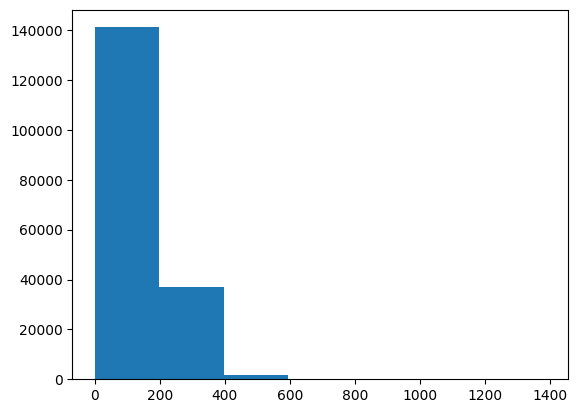

In [ ]:
import matplotlib.pyplot as plt
plt.hist(char_lens, bins = 7)

In [ ]:
output_char_len = int(np.percentile(char_lens, 95))
output_char_len

290

In [ ]:
# For character level embedding we need all keyboard characters
import string
all_chars = string.ascii_lowercase + string.digits + string.punctuation
all_chars

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Character vectorizer
NUM_CHAR_TOKENS = len(all_chars) + 2
char_vector = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                output_sequence_length = output_char_len,
                                standardize="lower_and_strip_punctuation",
                                name="char_vector")

char_vector.adapt(train_chars)

In [ ]:
char_vocab = char_vector.get_vocabulary()
print(len(char_vocab))
print(f"Most common characters: {char_vocab[:5]}")
print(f"Least common characters: {char_vocab[-5:]}")

28
Most common characters: ['', '[UNK]', 'e', 't', 'i']
Least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Testing the char_vector
random_chars = random.choice(train_chars)
print(f"Characters:\n {random_chars}")
print(f"Length of chars: {len(random_chars.split())}")
vectorized_chars = char_vector([random_chars])
print(f"Vectorized Characters:\n {vectorized_chars}")
print(f"Length of vectorized chars: {len(vectorized_chars[0])}")

Characters:
 t h i s   s i n g l e - c e n t e r   ,   p r o s p e c t i v e   ,   d o u b l e - m a s k e d   ,   r a n d o m i z e d   c l i n i c a l   t r i a l   c o n s i s t e d   o f   @   p a t i e n t s   w h o   w e r e   s c h e d u l e d   f o r   c a t a r a c t   s u r g e r y   .
Length of chars: 122
Vectorized Characters:
 [[ 3 13  4  9  9  4  6 18 12  2 11  2  6  3  2  8 14  8  7  9 14  2 11  3
   4 21  2 10  7 16 22 12  2 15  5  9 23  2 10  8  5  6 10  7 15  4 25  2
  10 11 12  4  6  4 11  5 12  3  8  4  5 12 11  7  6  9  4  9  3  2 10  7
  17 14  5  3  4  2  6  3  9 20 13  7 20  2  8  2  9 11 13  2 10 16 12  2
  10 17  7  8 11  5  3  5  8  5 11  3  9 16  8 18  2  8 19  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

In [ ]:
# character embedding layer
char_embedding = layers.Embedding(input_dim=NUM_CHAR_TOKENS,
                                  output_dim=25,
                                  mask_zero=False,
                                  name="char_embedding")

# Testing the layer
print(f"Before embedding:\n {random_chars}")
chars_embedded = char_embedding(vectorized_chars)
print(f"After vectorization and embedding:\n {chars_embedded}")

Before embedding:
 t h i s   s i n g l e - c e n t e r   ,   p r o s p e c t i v e   ,   d o u b l e - m a s k e d   ,   r a n d o m i z e d   c l i n i c a l   t r i a l   c o n s i s t e d   o f   @   p a t i e n t s   w h o   w e r e   s c h e d u l e d   f o r   c a t a r a c t   s u r g e r y   .
After vectorization and embedding:
 [[[-0.01718903 -0.01871968 -0.02125466 ... -0.03012292  0.02874389
    0.04273221]
  [ 0.03922534 -0.04110398  0.02726675 ... -0.00624838 -0.04566551
   -0.0225589 ]
  [ 0.04169616 -0.04342858  0.0334076  ...  0.01342912 -0.01670691
    0.03308833]
  ...
  [ 0.00671424  0.01428064  0.00389303 ... -0.02393339 -0.01525994
   -0.04815013]
  [ 0.00671424  0.01428064  0.00389303 ... -0.02393339 -0.01525994
   -0.04815013]
  [ 0.00671424  0.01428064  0.00389303 ... -0.02393339 -0.01525994
   -0.04815013]]]


In [ ]:
# Model
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vector(inputs)
char_embeddings = char_embedding(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_4 = tf.keras.Model(inputs=inputs,outputs=outputs,name="Conv_1D_char_embedding")

# Compile
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_4.summary()

Model: "Conv_1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vector (TextVectoriza  (None, 290)               0         
 tion)                                                           
                                                                 
 char_embedding (Embedding)  (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 5)      

In [ ]:
# Character datasets
train_char_data = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_data = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
model_4_history = model_4.fit(train_char_data,
                              steps_per_epoch=int(0.1 * len(train_char_data)),
                              epochs=5,
                              validation_data=val_char_data,
                              validation_steps=int(0.1*len(val_char_data)))

Epoch 1/5
562/562 [==============================] - 13s 23ms/step - loss: 1.0700 - accuracy: 0.5706 - val_loss: 0.9929 - val_accuracy: 0.6017
Epoch 2/5
562/562 [==============================] - 12s 22ms/step - loss: 0.9769 - accuracy: 0.6088 - val_loss: 0.9293 - val_accuracy: 0.6326
Epoch 3/5
562/562 [==============================] - 12s 21ms/step - loss: 0.9150 - accuracy: 0.6406 - val_loss: 0.8624 - val_accuracy: 0.6639
Epoch 4/5
562/562 [==============================] - 12s 21ms/step - loss: 0.8684 - accuracy: 0.6596 - val_loss: 0.8396 - val_accuracy: 0.6702
Epoch 5/5
562/562 [==============================] - 11s 19ms/step - loss: 0.8579 - accuracy: 0.6662 - val_loss: 0.8151 - val_accuracy: 0.6858


In [ ]:
model_4.evaluate(val_char_data)

945/945 [==============================] - 10s 11ms/step - loss: 0.8263 - accuracy: 0.6795


[0.8262682557106018, 0.6794981956481934]

In [ ]:
model_4_pred_probs = model_4.predict(val_char_data)
model_4_pred_probs

945/945 [==============================] - 6s 6ms/step


array([[0.17708111, 0.42900568, 0.07655774, 0.29449874, 0.02285667],
       [0.19452071, 0.47435772, 0.00578924, 0.32224035, 0.00309192],
       [0.10742899, 0.16622797, 0.11438057, 0.57352406, 0.03843841],
       ...,
       [0.01429184, 0.03247282, 0.07101202, 0.02164043, 0.8605828 ],
       [0.08916277, 0.24207565, 0.30146125, 0.06569823, 0.3016021 ],
       [0.31754518, 0.5078151 , 0.12031554, 0.03658337, 0.01774075]],
      dtype=float32)

In [ ]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [ ]:
model_4_results = calculate_results(val_labels_encoded,
                                    model_4_preds)
model_4_results

{'accuracy': 67.94982126307427,
 'precision': 0.6785553183155898,
 'recall': 0.6794982126307427,
 'f1': 0.6748782838916942}

Combining Pretrained token embeddings and character embeddings.

In [ ]:
# token inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_output)

# char inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vector(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_outputs = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_outputs)

# Combining them together
combined_model = layers.Concatenate(name="token_char_combined")([token_model.output,
                                                                 char_model.output])

# adding dropout for regularization
combined_dropout = layers.Dropout(0.5)(combined_model)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# Model
model_5 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="combined_chars_and_tokens")

In [ ]:
# Summary
model_5.summary()

Model: "combined_chars_and_tokens"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vector (TextVectoriza  (None, 290)                  0         ['char_input[0][0]']          
 tion)                                                                                            
                                                                                                  
 USE (KerasLayer)            (None, 512)                  2567978   ['toke

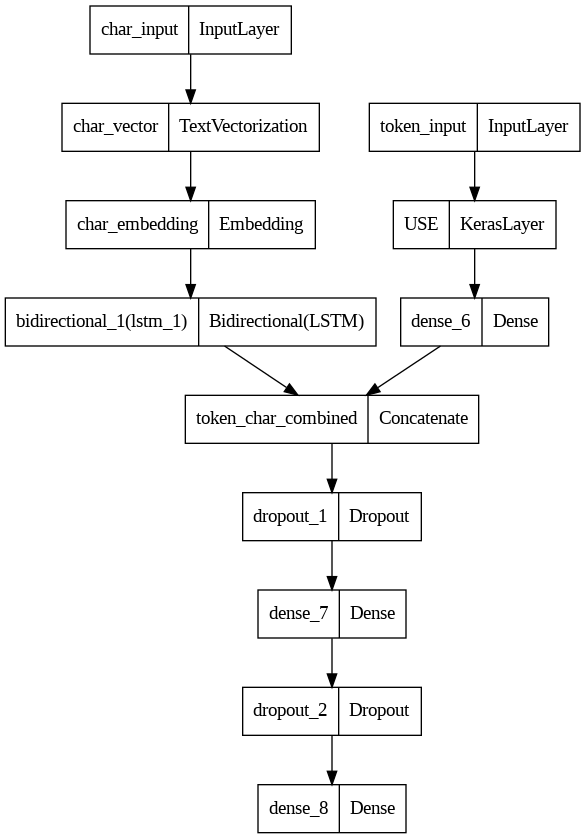

In [ ]:
# How the model works
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [ ]:
model_5.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Combined chars and tokens data
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
model_5_history = model_5.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              epochs=5,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/5
562/562 [==============================] - 137s 230ms/step - loss: 0.9687 - accuracy: 0.6183 - val_loss: 0.7857 - val_accuracy: 0.6955
Epoch 2/5
562/562 [==============================] - 119s 213ms/step - loss: 0.7915 - accuracy: 0.6945 - val_loss: 0.7154 - val_accuracy: 0.7284
Epoch 3/5
562/562 [==============================] - 114s 202ms/step - loss: 0.7686 - accuracy: 0.7066 - val_loss: 0.6882 - val_accuracy: 0.7367
Epoch 4/5
562/562 [==============================] - 115s 205ms/step - loss: 0.7387 - accuracy: 0.7204 - val_loss: 0.6685 - val_accuracy: 0.7533
Epoch 5/5
562/562 [==============================] - 115s 204ms/step - loss: 0.7408 - accuracy: 0.7220 - val_loss: 0.6552 - val_accuracy: 0.7527


In [ ]:
model_5.evaluate(val_char_token_dataset)

945/945 [==============================] - 50s 53ms/step - loss: 0.6606 - accuracy: 0.7492


[0.6606332659721375, 0.7492055892944336]

In [ ]:
model_5_pred_probs = model_5.predict(val_char_token_dataset)
model_5_pred_probs

945/945 [==============================] - 51s 52ms/step


array([[5.7501096e-01, 1.8524212e-01, 3.8606434e-03, 2.2700205e-01,
        8.8843629e-03],
       [4.3245557e-01, 4.6453267e-01, 5.2133910e-03, 9.4869502e-02,
        2.9288069e-03],
       [3.2045707e-01, 3.2131132e-02, 4.3407399e-02, 5.9065741e-01,
        1.3346916e-02],
       ...,
       [3.4588206e-04, 1.5025693e-03, 5.3075042e-02, 9.3294817e-05,
        9.4498318e-01],
       [6.0111973e-03, 3.2809991e-02, 2.8375664e-01, 2.9565187e-03,
        6.7446566e-01],
       [2.0049892e-01, 4.5357406e-01, 2.8907558e-01, 8.4946975e-03,
        4.8356783e-02]], dtype=float32)

In [ ]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [ ]:
model_5_results = calculate_results(val_labels_encoded, model_5_preds)

Combining transfer learning with pretrained token embeddings, character embeddings and positional embeddings.

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


The line number and total_lines can be used for positional embeddings, as these features are available during the test times.

One hot encoding is required here, as line_number=5 might be interpreted as 5 times greater than a line_number=1

In [ ]:
train_df["line_number"].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

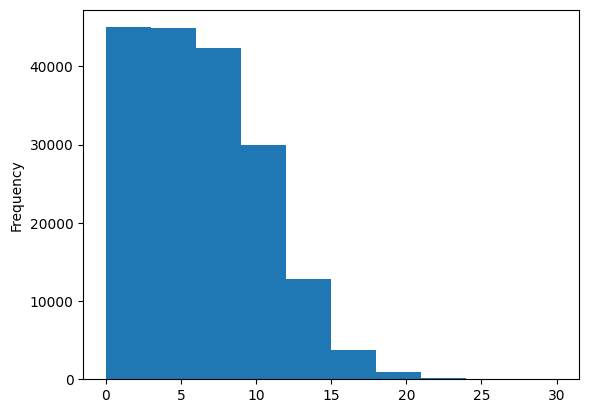

In [ ]:
train_df["line_number"].plot.hist()

This plot indicates that, maajority of lines have a position of 15 or less.

In [ ]:
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

depth=15 means any sample with line_number > 15 gets set to a tensor of all zeros, while for samples with line_number < 15 they are set into a tensor of all 0's but a 1 at the index=line_number

In [ ]:
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]),
 <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.

In [ ]:
train_df["total_lines"].value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

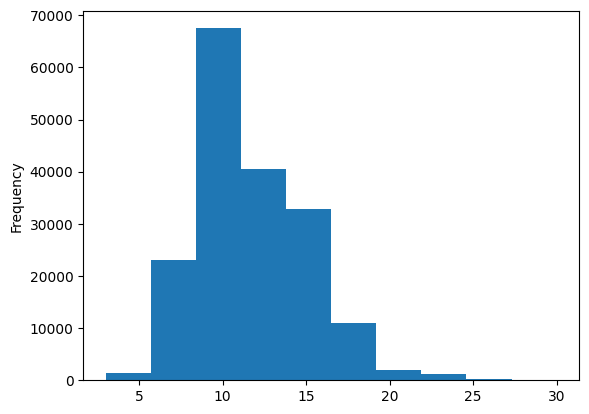

In [ ]:
train_df["total_lines"].plot.hist()

In [ ]:
depth = np.percentile(train_df["total_lines"], 98)
depth

20.0

In [ ]:
# one hot encode
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=depth)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=depth)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=depth)

In [ ]:
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

Creating a model combining all these factors.

In [ ]:
# Token inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

# Character inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vector(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_outputs = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_outputs)

# Line number inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_inputs")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, x)

# Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_inputs")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, y)

# Combining token and char embeddings
combined_embeddings = layers.Concatenate(name="combined_token_char")([token_model.output,
                                                                      char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# Combining positional embeddings
z = layers.Concatenate(name="combined_token_char_positional")([line_number_model.output,
                                                               total_lines_model.output,
                                                               z])

# Output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# Model
model_6 = tf.keras.Model(inputs=[line_number_model.input, total_lines_model.input, token_model.input, char_model.input],
                         outputs=output_layer)

In [ ]:
model_6.summary()

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vector (TextVectoriza  (None, 290)                  0         ['char_inputs[0][0]']         
 tion)                                                                                            
                                                                                                  
 USE (KerasLayer)            (None, 512)                  2567978   ['token_inputs[0][0]'] 

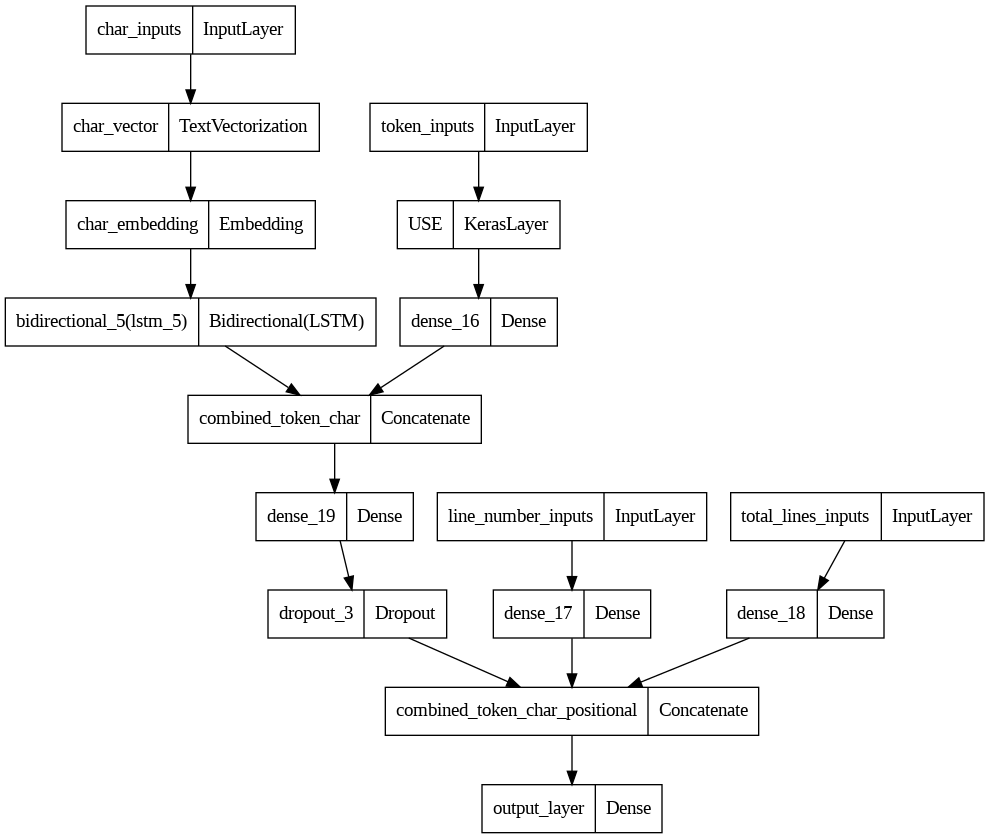

In [ ]:
plot_model(model_6)

In [ ]:
for layer in model_6.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7d4dcbf8aa40> True
<keras.src.engine.input_layer.InputLayer object at 0x7d4dcbf91d20> True
<keras.src.layers.preprocessing.text_vectorization.TextVectorization object at 0x7d4dcf2e30d0> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7d4e29b70700> False
<keras.src.layers.core.embedding.Embedding object at 0x7d4e1a7c75e0> True
<keras.src.layers.core.dense.Dense object at 0x7d4dcbf89960> True
<keras.src.layers.rnn.bidirectional.Bidirectional object at 0x7d4dcc2d3130> True
<keras.src.layers.merging.concatenate.Concatenate object at 0x7d4dc9396fb0> True
<keras.src.engine.input_layer.InputLayer object at 0x7d4dcbfa0850> True
<keras.src.engine.input_layer.InputLayer object at 0x7d4dcc2e7520> True
<keras.src.layers.core.dense.Dense object at 0x7d4dc949e770> True
<keras.src.layers.core.dense.Dense object at 0x7d4dcbf7f580> True
<keras.src.layers.core.dense.Dense object at 0x7d4dcc2e40d0> True
<keras.src.layers.regularization.dropout.

label_smoothing helps to regularize the model by making sure there is no focus on applying on one particular label to a sample.

In [ ]:
# Compile
model_6.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Creating training and validation datasets for the model_6

train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels))
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
history_model_6 = model_6.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1*len(train_pos_char_token_dataset)),
                              epochs=5,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1*len(val_pos_char_token_dataset)))

Epoch 1/5
562/562 [==============================] - 196s 331ms/step - loss: 1.0976 - accuracy: 0.7230 - val_loss: 0.9815 - val_accuracy: 0.8042
Epoch 2/5
562/562 [==============================] - 121s 214ms/step - loss: 0.9667 - accuracy: 0.8166 - val_loss: 0.9505 - val_accuracy: 0.8268
Epoch 3/5
562/562 [==============================] - 119s 211ms/step - loss: 0.9497 - accuracy: 0.8230 - val_loss: 0.9377 - val_accuracy: 0.8301
Epoch 4/5
562/562 [==============================] - 121s 216ms/step - loss: 0.9405 - accuracy: 0.8348 - val_loss: 0.9295 - val_accuracy: 0.8361
Epoch 5/5
562/562 [==============================] - 119s 213ms/step - loss: 0.9370 - accuracy: 0.8357 - val_loss: 0.9225 - val_accuracy: 0.8434


In [ ]:
model_6_pred_probs = model_6.predict(val_pos_char_token_dataset)
model_6_pred_probs

945/945 [==============================] - 52s 53ms/step


array([[0.61122704, 0.07499856, 0.01525202, 0.27531907, 0.02320326],
       [0.61912876, 0.07978041, 0.08768595, 0.19986531, 0.01353956],
       [0.35429156, 0.0871852 , 0.11242412, 0.39678195, 0.04931717],
       ...,
       [0.02925747, 0.06703438, 0.0462504 , 0.02720375, 0.83025396],
       [0.01955817, 0.2761697 , 0.12050525, 0.02180478, 0.5619621 ],
       [0.09523205, 0.73385257, 0.08999606, 0.02132409, 0.0595951 ]],
      dtype=float32)

In [ ]:
model_6_preds = tf.argmax(model_6_pred_probs, axis=1)
model_6_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
model_6_results = calculate_results(val_labels_encoded, model_6_preds)
model_6_results

{'accuracy': 84.1884019594863,
 'precision': 0.8442190703607891,
 'recall': 0.8418840195948629,
 'f1': 0.8383565687811692}

Comparing Model results.

In [ ]:
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "Conv1D_token_embed": model_2_results,
                                  "pretrained_token_embed": model_3_results,
                                  "custom_char_embed": model_4_results,
                                  "char_token_combined": model_5_results,
                                  "pos_char_token_combined": model_6_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
Conv1D_token_embed,80.050973,0.800942,0.800510,0.797232
pretrained_token_embed,73.073613,0.727603,0.730736,0.725029
custom_char_embed,67.949821,0.678555,0.679498,0.674878
char_token_combined,74.920561,0.743758,0.749206,0.744088
pos_char_token_combined,84.188402,0.844219,0.841884,0.838357


In [ ]:
# Accuracy on the same scale
all_model_results.accuracy = all_model_results.accuracy / 100

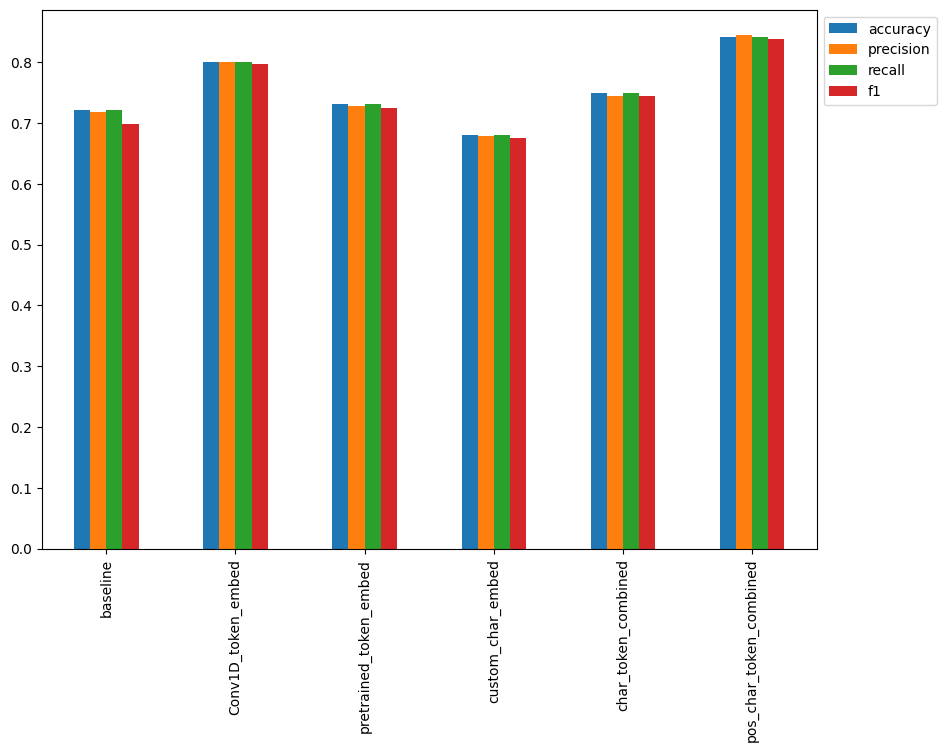

In [ ]:
all_model_results.plot(kind="bar",
                       figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0))


In [ ]:
# Sorting models by f1 scores
all_model_results.sort_values("f1", ascending=False)["f1"]

pos_char_token_combined    0.838357
Conv1D_token_embed         0.797232
char_token_combined        0.744088
pretrained_token_embed     0.725029
baseline                   0.698925
custom_char_embed          0.674878
Name: f1, dtype: float64

<Axes: >

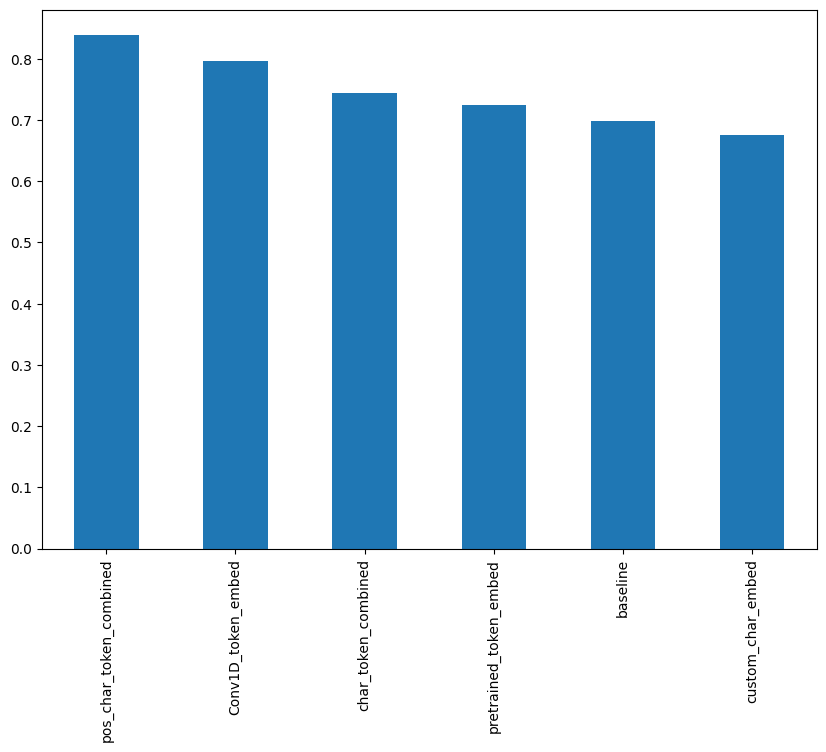

In [ ]:
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar",
                                                                figsize=(10,7))

Based on the observations, the combined model for positional, character and token embeddings performs the best.

Making some predictions.

In [ ]:
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_pos_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
test_pred_probs = model_6.predict(test_pos_char_token_dataset)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 81s 86ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 4, 2, 1, 1, 0])>

In [ ]:
test_results = calculate_results(test_labels_encoded, test_preds)
test_results

{'accuracy': 83.54405176704827,
 'precision': 0.8370099162527589,
 'recall': 0.8354405176704828,
 'f1': 0.831921211403295}

Finding the Most Wrong examples.

In [ ]:
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'METHODS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'METHODS',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULT

In [ ]:
# Adding a prediction to the dataframe
test_df["prediction"] = test_pred_classes
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy()
test_df["correct"] = test_df["prediction"] == test_df["target"]
test_df

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.370842,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,METHODS,0.514538,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.826100,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.851853,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.711973,True
...,...,...,...,...,...,...,...
30130,RESULTS,there was a statistically significant between-...,13,17,RESULTS,0.804751,True
30131,RESULTS,there were no statistically significant betwee...,14,17,RESULTS,0.695143,True
30132,RESULTS,there was no significant association between s...,15,17,RESULTS,0.689381,True
30133,RESULTS,no adverse effects were reported .,16,17,RESULTS,0.691303,True


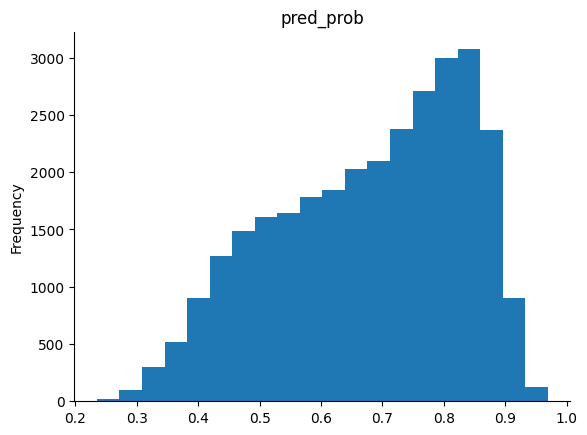

In [ ]:
# @title pred_prob

from matplotlib import pyplot as plt
test_df['pred_prob'].plot(kind='hist', bins=20, title='pred_prob')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Most wrong samples
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.960764,False
18720,RESULTS,non-diffuse-trickling '' ) .,8,15,BACKGROUND,0.945280,False
8545,METHODS,pretest-posttest .,1,11,BACKGROUND,0.944161,False
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,13,METHODS,0.938661,False
6027,RESULTS,patients were randomized in a bayesian respons...,4,15,METHODS,0.928675,False
...,...,...,...,...,...,...,...
29097,BACKGROUND,the primary endpoint was change from baseline ...,4,15,METHODS,0.855917,False
19425,RESULTS,a decision-analytical model based on patient-l...,3,12,METHODS,0.855751,False
26090,RESULTS,co-primary endpoints were peak change from bas...,2,10,METHODS,0.855296,False
6856,OBJECTIVE,there are currently no therapies to prevent or...,2,16,BACKGROUND,0.855106,False


In [ ]:
# top wrong preds
for row in top_100_wrong[0:10].itertuples():
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: CONCLUSIONS, Pred: METHODS, Prob: 0.9607638716697693, Line number: 4, Total lines: 6

Text:
symptom outcomes will be assessed and estimates of cost-effectiveness made .

-----

Target: RESULTS, Pred: BACKGROUND, Prob: 0.945280134677887, Line number: 8, Total lines: 15

Text:
non-diffuse-trickling '' ) .

-----

Target: METHODS, Pred: BACKGROUND, Prob: 0.9441605806350708, Line number: 1, Total lines: 11

Text:
pretest-posttest .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9386605620384216, Line number: 4, Total lines: 13

Text:
the primary endpoint is the cumulative three-year hiv incidence .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9286747574806213, Line number: 4, Total lines: 15

Text:
patients were randomized in a bayesian response-adaptive design to receive intravenous decitabine @ mg/m ( @ ) daily for @ days or decitabine plus oral valproic acid @ mg/kg daily for @ days .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9271348118782043, Line number: 2, Total lin

Example Predictions

In [ ]:
# example abstracts

import json
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

--2024-06-07 14:07:27--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2024-06-07 14:07:27 (49.9 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [ ]:
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [ ]:
# Creating sentencizer
from spacy.lang.en import English
nlp = English()

sentencizer = nlp.add_pipe("sentencizer")

# doc of parsed sequences
doc = nlp(example_abstracts[0]["abstract"])
abstract_lines = [str(sent) for sent in list(doc.sents)]
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [ ]:
total_lines_in_sample = len(abstract_lines)

In [ ]:
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)

sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

In [ ]:
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]

test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15)
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [ ]:
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]

test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [ ]:
# Characters
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [ ]:
test_abstract_pred_probs = model_6.predict(x=(test_abstract_line_numbers_one_hot,
                                              test_abstract_total_lines_one_hot,
                                              tf.constant(abstract_lines),
                                              tf.constant(abstract_chars)))
test_abstract_pred_probs

1/1 [==============================] - 2s 2s/step


array([[0.30882248, 0.08249022, 0.02972965, 0.5264598 , 0.05249779],
       [0.06726196, 0.03393966, 0.76530325, 0.08299722, 0.05049776],
       [0.10199638, 0.05188659, 0.6323387 , 0.12312599, 0.09065235],
       [0.11385749, 0.15035395, 0.5005867 , 0.07121066, 0.16399129],
       [0.05339206, 0.08769829, 0.4801228 , 0.04474202, 0.3340448 ],
       [0.03639578, 0.09410889, 0.65573484, 0.04052636, 0.17323399],
       [0.03374448, 0.23337945, 0.10949598, 0.02705779, 0.59632224],
       [0.01873967, 0.1622659 , 0.3349299 , 0.03072288, 0.45334175]],
      dtype=float32)

In [ ]:
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 2, 2, 4, 4])>

In [ ]:
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [ ]:
# Better presentation
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
METHODS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.
